In [15]:
# !pip3 install kaggle
# !pip3 install cv2

!kaggle --version

!which kaggle

/Users/sanketpatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Kaggle API 1.7.4.2
/Users/sanketpatel/Library/Python/3.9/bin/kaggle


In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2, VGG19, DenseNet169, EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [ ]:
kaggle_dir = os.path.expanduser("~/.kaggle")

# Replace with your actual Kaggle API credentials
kaggle_json = """{
  "username": "ovpatel",
  "key": "1f8296429204f5e64164e62f0b8a0b28"
}"""

# Save API Key to the correct location
os.makedirs(kaggle_dir, exist_ok=True)

# Save the file
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    f.write(kaggle_json)

# Set file permissions (important for security)
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

print(f"Kaggle API Key stored successfully in {kaggle_dir}")


!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images --force -p /content/


import zipfile

dataset_name = "hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images"
dataset_zip_path = os.path.join(kaggle_dir, "melanoma-skin-cancer-dataset-of-10000-images.zip")

#  Download the dataset
if not os.path.exists(dataset_zip_path):
    print(" Downloading dataset...")
    os.system(f"kaggle datasets download -d {dataset_name} -p {kaggle_dir} --force")
else:
    print(" Dataset already downloaded.")

#  Extract the dataset
extract_path = os.path.join(kaggle_dir, "melanoma_cancer_dataset")

if os.path.exists(dataset_zip_path):
    print(" Extracting dataset...")
    with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(" Extraction Complete.")
else:
    print(" Error: Dataset file not found! Please check the download step.")

#  Verify extracted dataset structure
print("Checking dataset structure...")

os.system(f"ls {extract_path}")


Kaggle API Key stored successfully in /Users/sanketpatel/.kaggle
/Users/sanketpatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
[Errno 30] Read-only file system: '/content'
✅ Dataset already downloaded.
📂 Extracting dataset...
✅ Extraction Complete.
Checking dataset structure...
melanoma_cancer_dataset


0

# Define labels and image size


In [18]:

LABELS = ['malignant', 'benign']
IMG_SIZE = 224

# Load training and testing data


In [ ]:


# Function to load images properly
def load_data(directory, img_size=(IMG_SIZE, IMG_SIZE), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

# Load datasets
train_dir = kaggle_dir + "/melanoma_cancer_dataset/melanoma_cancer_dataset/train"
test_dir = kaggle_dir + "/melanoma_cancer_dataset/melanoma_cancer_dataset/test"

train_data = load_data(train_dir)
test_data = load_data(test_dir)

# Verify dataset
print(f" Train data loaded: {train_data}")
print(f" Test data loaded: {test_data}")





Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
✅ Train data loaded: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
✅ Test data loaded: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Prepare dataset for training


In [ ]:

for x_batch, y_batch in train_data.take(1):
    print(f"Batch shape: {x_batch.shape}")

# Convert train dataset to NumPy arrays
X_train = np.concatenate([x.numpy() for x, y in train_data], axis=0)
y_train = np.concatenate([y.numpy() for x, y in train_data], axis=0)

# Convert test dataset to NumPy arrays
X_test = np.concatenate([x.numpy() for x, y in test_data], axis=0)
y_test = np.concatenate([y.numpy() for x, y in test_data], axis=0)

# Merge train and test sets
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

#  Check the final shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")


Batch shape: (32, 224, 224, 3)


2025-04-04 00:59:40.611081: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X shape: (10605, 224, 224, 3), y shape: (10605,)


# Reshape and normalize images


In [21]:
print(f"Original shape of X: {X.shape}")

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0


Original shape of X: (10605, 224, 224, 3)


# Split data into training, validation, and test sets


In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=32)

# Data augmentation


In [23]:

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.9614687216681777), 1: np.float64(1.0417485265225934)}


# Resnet50V2 Model


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.8062 - loss: 0.4332 - val_accuracy: 0.9020 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9085 - loss: 0.2295 - val_accuracy: 0.8870 - val_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.9081 - loss: 0.2335 - val_accuracy: 0.8810 - val_loss: 0.3602 - learning_rate: 1.0000e-04
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.9182 - loss: 0.2129 - val_accuracy: 0.9130 - val_loss: 0.2040 - learning_rate: 1.0000e-04
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.9189 - loss: 0.2068 - val_accuracy: 0.9070 - val_loss: 0.2065 - learning_rate: 1.0000e-04
Epoch 6/10
3

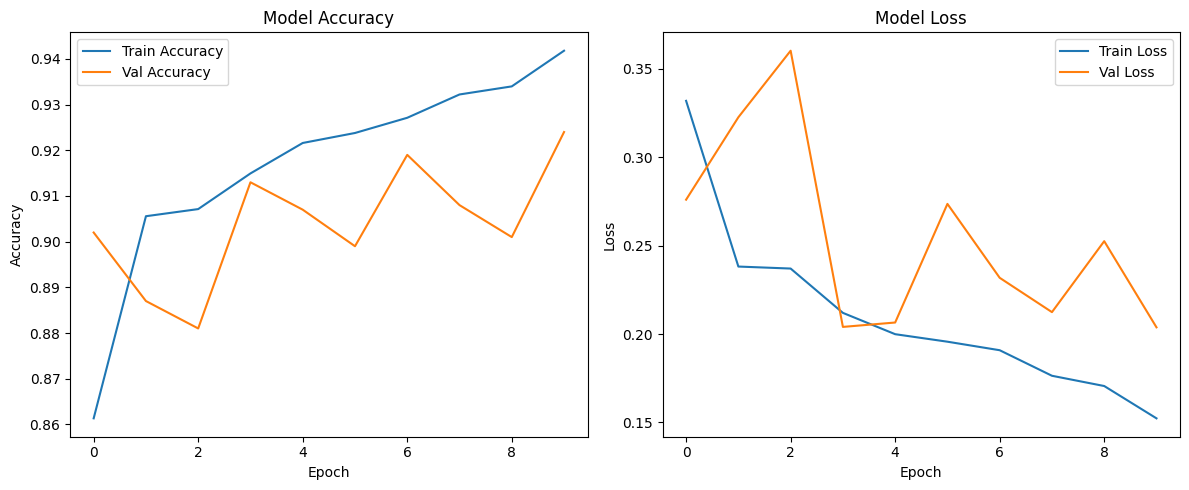

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 411ms/step


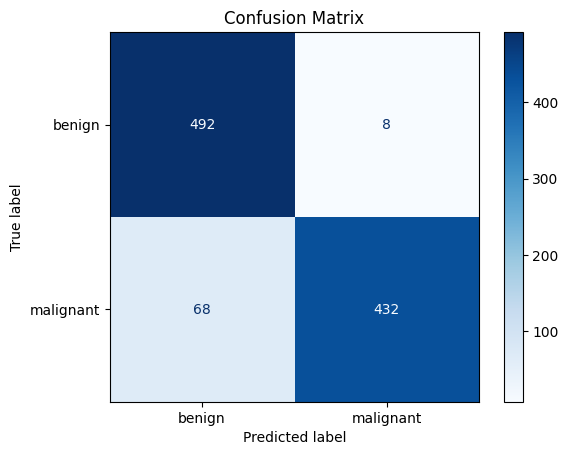


Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.98      0.93       500
   malignant       0.98      0.86      0.92       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000



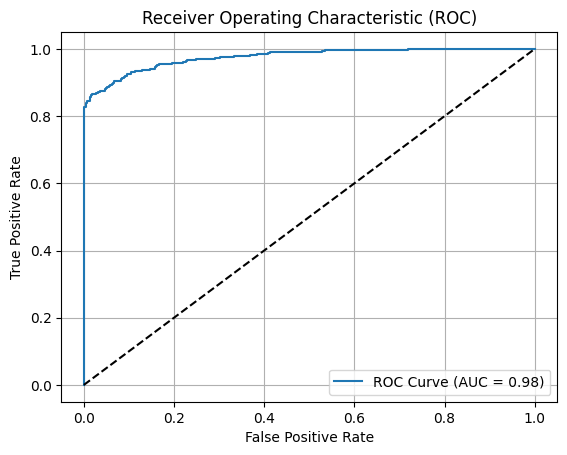

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Print class index mapping
print("Class Indices:", test_generator.class_indices)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Model Architecture
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True  # Fine-tune all layers (adjust to unfreeze specific layers if needed)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights
    )

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show() 

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# EfficientNetB2

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5075 - loss: 0.1162
Epoch 1: val_loss improved from inf to 0.05559, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 143s 230ms/step - accuracy: 0.5075 - loss: 0.1161 - val_accuracy: 0.5000 - val_loss: 0.0556 - learning_rate: 1.0000e-04
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.4974 - loss: 0.0852
Epoch 2: val_loss improved from 0.05559 to 0.04584, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 140s 233ms/step - accuracy: 0.4974 - loss: 0.0852 - val_accuracy: 0.5000 - val_loss: 0.0458 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5090 - loss: 0.0750
Epoch 3: val_loss did not improve from 0.04584
601/601 ━━━━━━━━━━━━━━━━━━━━ 141s 235ms/step - accuracy: 0.5090 - loss: 0.0750 - val_accuracy: 0.5000 - val_loss: 0.0571 - learning_rate: 1.0000e-04
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5144 - loss: 0.0685
Epoch 4: val_loss improved from 0.04584 to 0.04442, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 141s 235ms/step - accuracy: 0.5144 - loss: 0.0685 - val_accuracy: 0.4990 - val_loss: 0.0444 - learning_rate: 1.0000e-04
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5144 - loss: 0.0657
Epoch 5: val_loss improved from 0.04442 to 0.04213, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 140s 233ms/step - accuracy: 0.5144 - loss: 0.0656 - val_accuracy: 0.4980 - val_loss: 0.0421 - learning_rate: 1.0000e-04
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5021 - loss: 0.0625
Epoch 6: val_loss improved from 0.04213 to 0.04155, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 147s 244ms/step - accuracy: 0.5021 - loss: 0.0625 - val_accuracy: 0.4780 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5251 - loss: 0.0591
Epoch 7: val_loss did not improve from 0.04155
601/601 ━━━━━━━━━━━━━━━━━━━━ 145s 241ms/step - accuracy: 0.5251 - loss: 0.0591 - val_accuracy: 0.4980 - val_loss: 0.0418 - learning_rate: 1.0000e-04
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5217 - loss: 0.0562
Epoch 8: val_loss improved from 0.04155 to 0.04151, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 146s 244ms/step - accuracy: 0.5217 - loss: 0.0562 - val_accuracy: 0.4940 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 9/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5123 - loss: 0.0543
Epoch 9: val_loss did not improve from 0.04151
601/601 ━━━━━━━━━━━━━━━━━━━━ 140s 232ms/step - accuracy: 0.5124 - loss: 0.0543 - val_accuracy: 0.6220 - val_loss: 0.0415 - learning_rate: 1.0000e-04
Epoch 10/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5396 - loss: 0.0512
Epoch 10: val_loss improved from 0.04151 to 0.04117, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 142s 236ms/step - accuracy: 0.5396 - loss: 0.0513 - val_accuracy: 0.6280 - val_loss: 0.0412 - learning_rate: 5.0000e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8669 - loss: 0.0353
Final Validation Accuracy: 62.80%


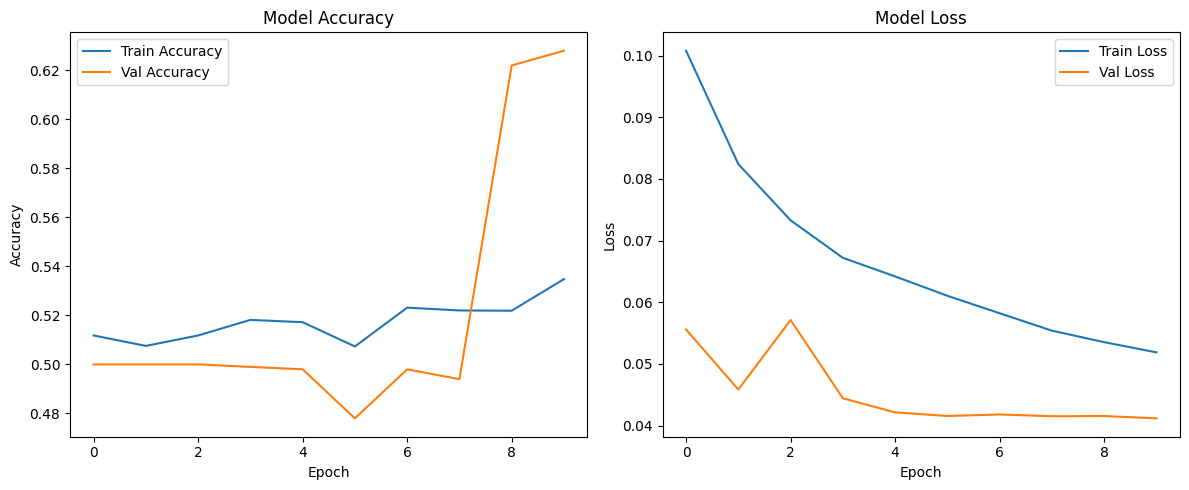

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step
Optimal Threshold: 0.47


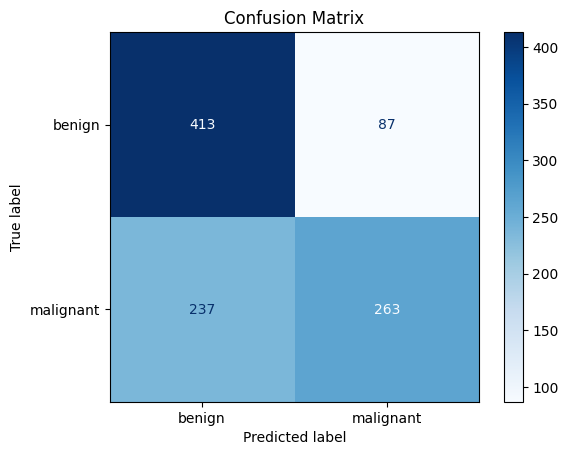


Classification Report:

              precision    recall  f1-score   support

      benign       0.64      0.83      0.72       500
   malignant       0.75      0.53      0.62       500

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.67      1000
weighted avg       0.69      0.68      0.67      1000



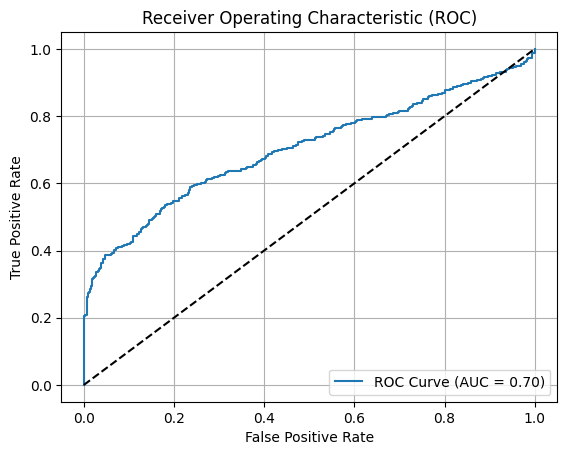

In [ ]:
# Skin Cancer Classification with EfficientNetB2 and Optimized Settings

# Set constants
IMG_SIZE = 260
BATCH_SIZE = 16

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB2 with partial layer freezing
base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# EfficientNetB3 Ephocs count = 10, Image Size 300

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5016 - loss: 0.1015
Epoch 1: val_loss improved from inf to 0.05125, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 294s 481ms/step - accuracy: 0.5016 - loss: 0.1015 - val_accuracy: 0.5020 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.5053 - loss: 0.0791
Epoch 2: val_loss improved from 0.05125 to 0.04156, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 298s 495ms/step - accuracy: 0.5053 - loss: 0.0791 - val_accuracy: 0.4980 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5057 - loss: 0.0714
Epoch 3: val_loss did not improve from 0.04156
601/601 ━━━━━━━━━━━━━━━━━━━━ 278s 463ms/step - accuracy: 0.5057 - loss: 0.0714 - val_accuracy: 0.4970 - val_loss: 0.0434 - learning_rate: 1.0000e-04
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5189 - loss: 0.0658
Epoch 4: val_loss did not improve from 0.04156
601/601 ━━━━━━━━━━━━━━━━━━━━ 284s 473ms/step - accuracy: 0.5189 - loss: 0.0658 - val_accuracy: 0.6820 - val_loss: 0.0419 - learning_rate: 1.0000e-04
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5295 - loss: 0.0600
Epoch 5: val_loss improved from 0.04156 to 0.04097, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 290s 482ms/step - accuracy: 0.5295 - loss: 0.0600 - val_accuracy: 0.6920 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5150 - loss: 0.0593
Epoch 6: val_loss did not improve from 0.04097
601/601 ━━━━━━━━━━━━━━━━━━━━ 291s 484ms/step - accuracy: 0.5150 - loss: 0.0593 - val_accuracy: 0.7240 - val_loss: 0.0412 - learning_rate: 1.0000e-04
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.5272 - loss: 0.0564
Epoch 7: val_loss did not improve from 0.04097
601/601 ━━━━━━━━━━━━━━━━━━━━ 290s 482ms/step - accuracy: 0.5272 - loss: 0.0564 - val_accuracy: 0.4990 - val_loss: 0.0422 - learning_rate: 1.0000e-04
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.5209 - loss: 0.0557
Epoch 8: val_loss did not improve from 0.04097
601/601 ━━━━━━━━━━━━━━━━━━━━ 288s 479ms/step - accuracy: 0.5209 - loss: 0.0557 - val_accuracy: 0.5760 - val_loss: 0.0415 - learning_rate: 1.0000e-04

601/601 ━━━━━━━━━━━━━━━━━━━━ 292s 486ms/step - accuracy: 0.5460 - loss: 0.0515 - val_accuracy: 0.6420 - val_loss: 0.0405 - learning_rate: 5.0000e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.7604 - loss: 0.0389
Final Validation Accuracy: 64.20%


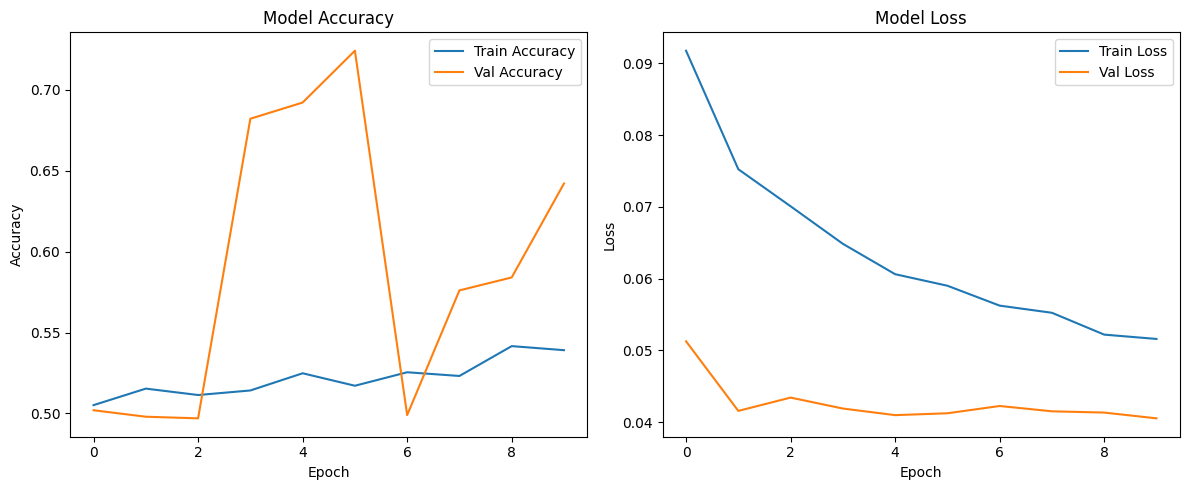

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step
Optimal Threshold: 0.48


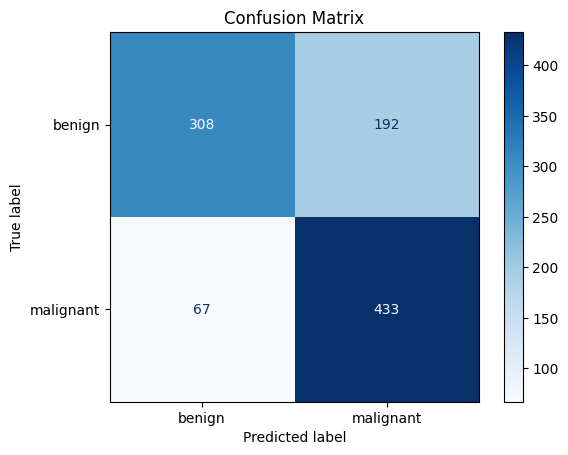


Classification Report:

              precision    recall  f1-score   support

      benign       0.82      0.62      0.70       500
   malignant       0.69      0.87      0.77       500

    accuracy                           0.74      1000
   macro avg       0.76      0.74      0.74      1000
weighted avg       0.76      0.74      0.74      1000



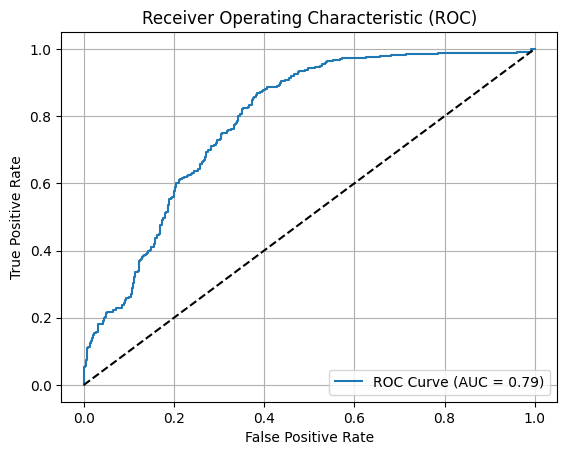

In [ ]:
# Skin Cancer Classification with EfficientNetB2 and Optimized Settings


from tensorflow.keras.applications import EfficientNetB3
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Set constants
IMG_SIZE = 300
BATCH_SIZE = 16 

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB2 with partial layer freezing
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# EfficientNetB4

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5097 - loss: 0.1088
Epoch 1: val_loss improved from inf to 0.04348, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 507s 832ms/step - accuracy: 0.5097 - loss: 0.1088 - val_accuracy: 0.5060 - val_loss: 0.0435 - learning_rate: 1.0000e-04
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.5133 - loss: 0.0821
Epoch 2: val_loss did not improve from 0.04348
601/601 ━━━━━━━━━━━━━━━━━━━━ 529s 880ms/step - accuracy: 0.5133 - loss: 0.0821 - val_accuracy: 0.5450 - val_loss: 0.0439 - learning_rate: 1.0000e-04
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.5160 - loss: 0.0727
Epoch 3: val_loss improved from 0.04348 to 0.04270, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 518s 861ms/step - accuracy: 0.5160 - loss: 0.0727 - val_accuracy: 0.5380 - val_loss: 0.0427 - learning_rate: 1.0000e-04
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.5175 - loss: 0.0686
Epoch 4: val_loss improved from 0.04270 to 0.04239, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 525s 873ms/step - accuracy: 0.5175 - loss: 0.0686 - val_accuracy: 0.5670 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 5/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.5203 - loss: 0.0635
Epoch 5: val_loss improved from 0.04239 to 0.04163, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 525s 874ms/step - accuracy: 0.5203 - loss: 0.0635 - val_accuracy: 0.5080 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 6/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.5099 - loss: 0.0628
Epoch 6: val_loss improved from 0.04163 to 0.04133, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 520s 865ms/step - accuracy: 0.5099 - loss: 0.0628 - val_accuracy: 0.6730 - val_loss: 0.0413 - learning_rate: 1.0000e-04
Epoch 7/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5231 - loss: 0.0569
Epoch 7: val_loss did not improve from 0.04133
601/601 ━━━━━━━━━━━━━━━━━━━━ 503s 836ms/step - accuracy: 0.5231 - loss: 0.0569 - val_accuracy: 0.6770 - val_loss: 0.0417 - learning_rate: 1.0000e-04
Epoch 8/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5267 - loss: 0.0564
Epoch 8: val_loss improved from 0.04133 to 0.04098, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 548s 913ms/step - accuracy: 0.5267 - loss: 0.0564 - val_accuracy: 0.6760 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 9/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.5287 - loss: 0.0544
Epoch 9: val_loss did not improve from 0.04098
601/601 ━━━━━━━━━━━━━━━━━━━━ 523s 870ms/step - accuracy: 0.5287 - loss: 0.0544 - val_accuracy: 0.6420 - val_loss: 0.0418 - learning_rate: 1.0000e-04
Epoch 10/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.5217 - loss: 0.0531
Epoch 10: val_loss did not improve from 0.04098
601/601 ━━━━━━━━━━━━━━━━━━━━ 506s 842ms/step - accuracy: 0.5217 - loss: 0.0531 - val_accuracy: 0.5090 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 11/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.5295 - loss: 0.0505
Epoch 11: val_loss did not improve from 0.04098
601/601 ━━━━━━━━━━━━━━━━━━━━ 506s 842ms/step - accuracy: 0.5295 - loss: 0.0505 - val_accuracy: 0.5020 - val_loss: 0.0420 - learning_rate: 1.0000

601/601 ━━━━━━━━━━━━━━━━━━━━ 523s 870ms/step - accuracy: 0.5295 - loss: 0.0498 - val_accuracy: 0.6710 - val_loss: 0.0402 - learning_rate: 5.0000e-05
Epoch 13/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5439 - loss: 0.0483
Epoch 13: val_loss did not improve from 0.04016
601/601 ━━━━━━━━━━━━━━━━━━━━ 522s 869ms/step - accuracy: 0.5439 - loss: 0.0483 - val_accuracy: 0.5480 - val_loss: 0.0404 - learning_rate: 5.0000e-05
Epoch 14/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.5333 - loss: 0.0487
Epoch 14: val_loss improved from 0.04016 to 0.03990, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 518s 861ms/step - accuracy: 0.5333 - loss: 0.0487 - val_accuracy: 0.6900 - val_loss: 0.0399 - learning_rate: 5.0000e-05
Epoch 15/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.5552 - loss: 0.0479
Epoch 15: val_loss did not improve from 0.03990
601/601 ━━━━━━━━━━━━━━━━━━━━ 519s 864ms/step - accuracy: 0.5552 - loss: 0.0479 - val_accuracy: 0.6260 - val_loss: 0.0407 - learning_rate: 5.0000e-05
Epoch 16/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.5366 - loss: 0.0479
Epoch 16: val_loss did not improve from 0.03990
601/601 ━━━━━━━━━━━━━━━━━━━━ 521s 867ms/step - accuracy: 0.5366 - loss: 0.0479 - val_accuracy: 0.5100 - val_loss: 0.0414 - learning_rate: 5.0000e-05
Epoch 17/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5516 - loss: 0.0474
Epoch 17: val_loss did not improve from 0.03990
601/601 ━━━━━━━━━━━━━━━━━━━━ 522s 868ms/step - accuracy: 0.5517 - loss: 0.0474 - val_accuracy: 0.5080 - val_loss: 0.0420 - learning_rate: 5.00

601/601 ━━━━━━━━━━━━━━━━━━━━ 525s 874ms/step - accuracy: 0.5459 - loss: 0.0469 - val_accuracy: 0.6800 - val_loss: 0.0386 - learning_rate: 2.5000e-05
Epoch 19/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.5757 - loss: 0.0454
Epoch 19: val_loss improved from 0.03859 to 0.03855, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 531s 884ms/step - accuracy: 0.5757 - loss: 0.0454 - val_accuracy: 0.6870 - val_loss: 0.0386 - learning_rate: 2.5000e-05
Epoch 20/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5585 - loss: 0.0464
Epoch 20: val_loss improved from 0.03855 to 0.03822, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 529s 880ms/step - accuracy: 0.5585 - loss: 0.0464 - val_accuracy: 0.6760 - val_loss: 0.0382 - learning_rate: 2.5000e-05
Epoch 21/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.5609 - loss: 0.0462
Epoch 21: val_loss did not improve from 0.03822
601/601 ━━━━━━━━━━━━━━━━━━━━ 523s 870ms/step - accuracy: 0.5609 - loss: 0.0462 - val_accuracy: 0.6830 - val_loss: 0.0383 - learning_rate: 2.5000e-05
Epoch 22/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.5792 - loss: 0.0449
Epoch 22: val_loss did not improve from 0.03822
601/601 ━━━━━━━━━━━━━━━━━━━━ 526s 875ms/step - accuracy: 0.5792 - loss: 0.0449 - val_accuracy: 0.6850 - val_loss: 0.0384 - learning_rate: 2.5000e-05
Epoch 23/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.5609 - loss: 0.0450
Epoch 23: val_loss did not improve from 0.03822
601/601 ━━━━━━━━━━━━━━━━━━━━ 536s 891ms/step - accuracy: 0.5609 - loss: 0.0450 - val_accuracy: 0.6850 - val_loss: 0.0382 - learning_rate: 2.50

601/601 ━━━━━━━━━━━━━━━━━━━━ 533s 886ms/step - accuracy: 0.5806 - loss: 0.0450 - val_accuracy: 0.6780 - val_loss: 0.0378 - learning_rate: 1.2500e-05
Epoch 25/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.5595 - loss: 0.0454
Epoch 25: val_loss improved from 0.03785 to 0.03779, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 518s 861ms/step - accuracy: 0.5595 - loss: 0.0454 - val_accuracy: 0.6880 - val_loss: 0.0378 - learning_rate: 1.2500e-05
Epoch 26/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5946 - loss: 0.0442
Epoch 26: val_loss improved from 0.03779 to 0.03778, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 510s 848ms/step - accuracy: 0.5946 - loss: 0.0442 - val_accuracy: 0.6870 - val_loss: 0.0378 - learning_rate: 1.2500e-05
Epoch 27/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.5748 - loss: 0.0446
Epoch 27: val_loss did not improve from 0.03778
601/601 ━━━━━━━━━━━━━━━━━━━━ 512s 852ms/step - accuracy: 0.5749 - loss: 0.0446 - val_accuracy: 0.6870 - val_loss: 0.0378 - learning_rate: 1.2500e-05
Epoch 28/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.5798 - loss: 0.0441
Epoch 28: val_loss did not improve from 0.03778
601/601 ━━━━━━━━━━━━━━━━━━━━ 514s 855ms/step - accuracy: 0.5798 - loss: 0.0441 - val_accuracy: 0.6880 - val_loss: 0.0379 - learning_rate: 6.2500e-06
Epoch 29/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.5772 - loss: 0.0443
Epoch 29: val_loss improved from 0.03778 to 0.03762, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 515s 856ms/step - accuracy: 0.5773 - loss: 0.0443 - val_accuracy: 0.6940 - val_loss: 0.0376 - learning_rate: 6.2500e-06
Epoch 30/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.5777 - loss: 0.0439
Epoch 30: val_loss did not improve from 0.03762
601/601 ━━━━━━━━━━━━━━━━━━━━ 522s 868ms/step - accuracy: 0.5777 - loss: 0.0439 - val_accuracy: 0.6900 - val_loss: 0.0380 - learning_rate: 6.2500e-06
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 626ms/step - accuracy: 0.6878 - loss: 0.0400
Final Validation Accuracy: 69.40%


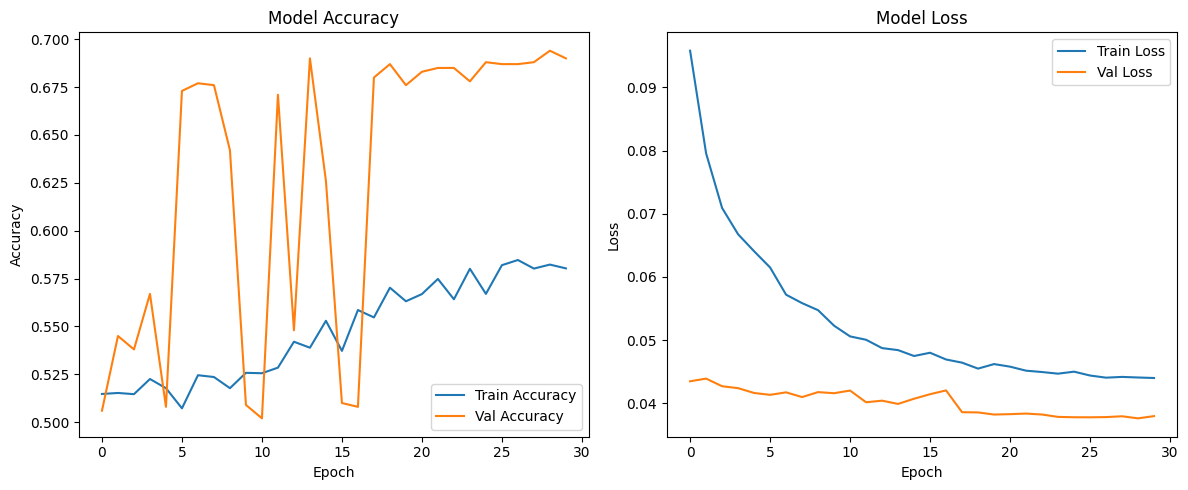

63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 684ms/step
Optimal Threshold: 0.49


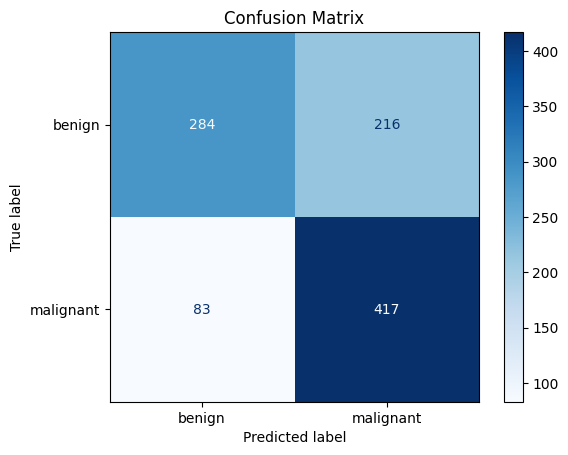


Classification Report:

              precision    recall  f1-score   support

      benign       0.77      0.57      0.66       500
   malignant       0.66      0.83      0.74       500

    accuracy                           0.70      1000
   macro avg       0.72      0.70      0.70      1000
weighted avg       0.72      0.70      0.70      1000



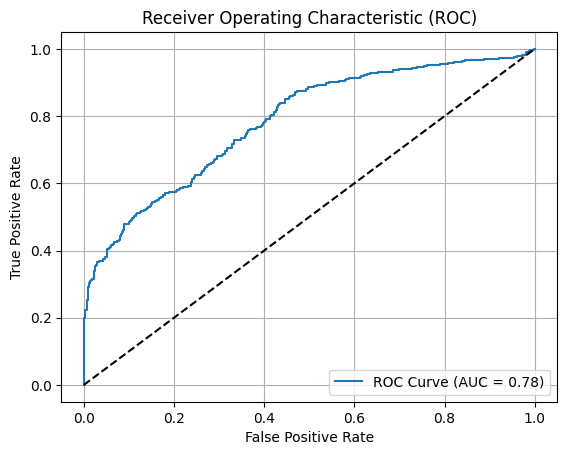

In [ ]:
# Skin Cancer Classification with EfficientNetB2 and Optimized Settings

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Set constants
IMG_SIZE = 380
BATCH_SIZE = 16

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB2 with partial layer freezing
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# CNN Model

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 83s 272ms/step - accuracy: 0.7945 - loss: 1.1689 - val_accuracy: 0.5090 - val_loss: 3.3329 - learning_rate: 1.0000e-04
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - accuracy: 0.8508 - loss: 0.6035 - val_accuracy: 0.8460 - val_loss: 0.3947 - learning_rate: 1.0000e-04
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 86s 285ms/step - accuracy: 0.8623 - loss: 0.4322 - val_accuracy: 0.8860 - val_loss: 0.3413 - learning_rate: 1.0000e-04
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 86s 287ms/step - accuracy: 0.8625 - loss: 0.3930 - val_accuracy: 0.8970 - val_loss: 0.2285 - learning_rate: 1.0000e-04
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 86s 286ms/step - accuracy: 0.8782 - loss: 0.3763 - val_accuracy: 0.9020 - val_loss: 0.2809 - learning_rate: 1.0000e-04
Ep

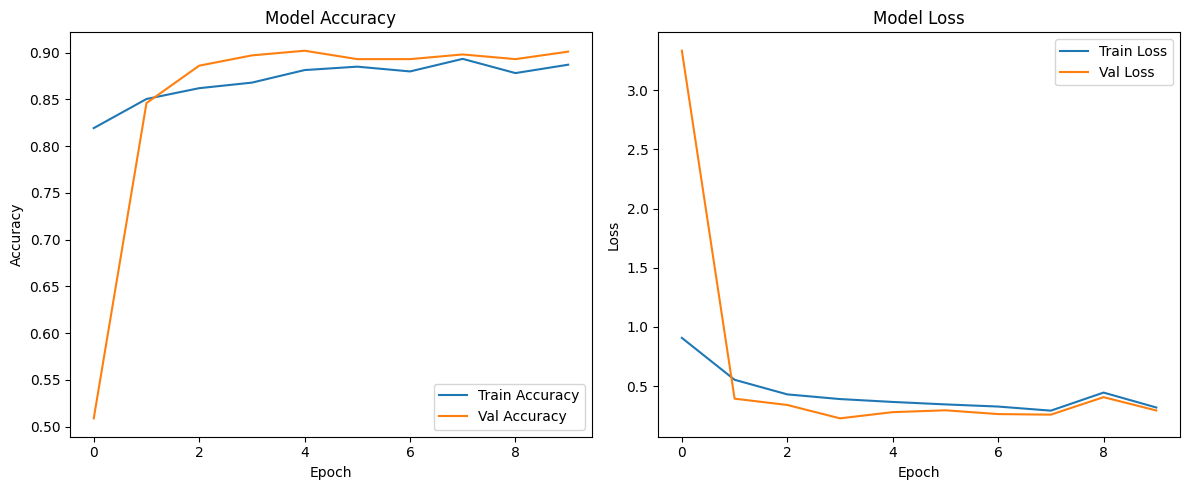

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


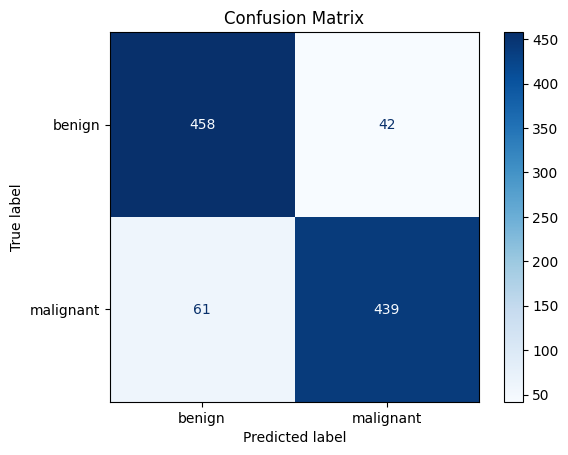


Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.92      0.90       500
   malignant       0.91      0.88      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



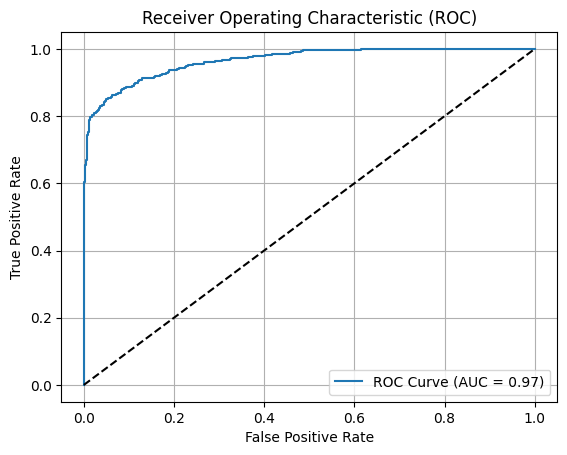

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Class Mapping
print("Class Indices:", test_generator.class_indices)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights
    )

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()